<a href="https://colab.research.google.com/github/Kontilenia/NLP/blob/main/SpamRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create neural network that recognise spam SMS.

Install and import all necessary packages  

In [1]:
!pip install transformers > /dev/null

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tqdm 
import numpy as np
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from transformers import AutoTokenizer, AutoModel
from torch import cuda
from sklearn.metrics import accuracy_score, f1_score

Check in which devide the code is going to run (CPU or GPU)

In [3]:
device = 'cuda' if cuda.is_available() else 'CPU'
print('current device is', device)

current device is cuda


Conect with google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Change folder in google drive

In [4]:
%cd /content/drive/MyDrive/data/spam

[Errno 2] No such file or directory: '/content/drive/MyDrive/data/spam'
/content


In [5]:
%cd /content/data

/content/data


Read the csv file that contains the dataset and create dictionaries for the labels of the dataset (ham or spam).

In [6]:
df = pd.read_csv("spam2.csv")
#df["target"].unique()
label2idx = { label:idx for  idx,label in enumerate(sorted(df.target.unique())) }
idx2label = { idx:label for  idx,label in enumerate(sorted(df.target.unique())) }
#df.head(0)

set_seed function is used in order to have the same random numbers every time

In [7]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
#set_seed(0)

SpamLineByLineDataset class is created in order to handle the dataset. 

In [8]:
class SpamLineByLineDataset(Dataset):

    def __init__(self, df, tokenizer,  max_len=100):    

    #Arguments:
        #df (Dataframe): A Dataframe with the dataset.
        #tokenizer: the bert tokenizer 
        #max_len: The maximum length of the token sequence        
        
        #self.transform = transform
        self.transform = transforms
        self.tokenizer = tokenizer
        self.df = df 
        self.max_len = max_len

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #text = self.df.loc[idx].tweet.lower()
        text = self.df.loc[idx].to_string()      
        
        if "target" in self.df.columns:
          target = df.loc[idx].target
          label = label2idx[target]
        else:
          label = -1

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            truncation=True,
            padding = "max_length"
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.int64), 
            'text' : text
        }

Load BERT and use it to create a SpamLineByLineDataset Object

In [9]:
base_model = "bert-base-multilingual-uncased"
tokenizer = AutoTokenizer.from_pretrained(base_model)
ds = SpamLineByLineDataset(df, tokenizer=tokenizer) 
#type(ds.__getitem__(0).get("text"))

Split the dataset in train and test sets. The train set is 80% of the dataset and the train set is 20% of the dataset.

In [10]:
set_seed(0)
test_size = int(len(ds)*0.2)
train_set, test_set = torch.utils.data.random_split(ds, [len(ds)-test_size, test_size])
#len(train_set), len(test_set)
#label2idx
#train_set[0]

SpamText class is created in order to handle the BERT pretrained neural network. 

In [11]:
class SpamText(torch.nn.Module):
    def __init__(self, base_model, num_outputs):
        super(SpamText, self).__init__()
        self.l1 = AutoModel.from_pretrained(base_model)
        self.linear = torch.nn.Linear(768 , num_outputs)
    
    def forward(self, ids, mask, token_type_ids ):
        text_feats =  self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)['pooler_output']
        output = self.linear(text_feats)
        return output
        return text_feats

Create SpamText object.

In [12]:
#set_seed(0)
#train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
#test_loader = DataLoader(test_set, batch_size=8, shuffle=False)
model = SpamText(base_model=base_model, num_outputs=len(idx2label)).to(device)
#data = next(iter(test_loader))
#ids = data['ids'].to(device, dtype = torch.long)
#mask = data['mask'].to(device, dtype = torch.long)
#token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
#targets = data['label'].to(device, dtype = torch.int64)
#outputs = model(ids, mask, token_type_ids)
#len(test_set)/8

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train function is used to train neural network by updating its weights.

In [13]:
def train(epoch, model, optimizer, criterion, training_loader):
    model.train()

    losses = [] 
    for _,data in enumerate(training_loader, 0):
    
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['label'].to(device, dtype = torch.int64)
        
        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()


        loss = criterion(outputs, targets)
        losses.append( loss.item())
      
        loss.backward()
        optimizer.step()

    print( f"Epoch {epoch}, mean epoch loss={np.mean(losses):.4}")

Validation function is used to take the ouputs of the neural network without updating its weights.   

In [14]:
def validation(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['label'].to(device, dtype = torch.int64) 
                       
            outputs = model(ids, mask, token_type_ids)

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.argmax(outputs, dim=1).cpu().detach().numpy().tolist())
    
    fin_outputs = np.array(fin_outputs)
    return fin_outputs, fin_targets

Clear cache memory of GPU and call set_seed function to take the same random numbers. Also, create two DataLoaders with train and test set. Train set is need to be shuffled for better performance.   

In [15]:
torch.cuda.empty_cache()
set_seed(0)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

Train neular network for one epoch. This code works also for more epochs. In this case only the model with the greatest accuracy is taken. 

In [16]:
import copy
set_seed(0)
print(f"training model")

best_score = 0 
model = SpamText(base_model=base_model, num_outputs=len(idx2label)).to(device)
LEARNING_RATE = 1e-05
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE) 
criterion = torch.nn.CrossEntropyLoss()
best_model_wts = copy.deepcopy(model.state_dict())
EPOCHS = 1

for epoch in range(EPOCHS):
    train(epoch, model, optimizer, criterion, training_loader=train_loader)
    outputs, targets = validation(model=model, testing_loader=test_loader)
    
    outputs = outputs.reshape(-1)
    targets = np.array(targets)
    accuracy = accuracy_score(targets, outputs)
    #f1_score_micro = f1_score(targets, outputs, average='micro')
    #f1_score_macro = f1_score(targets, outputs, average='macro')

    #print(f"Epoch {epoch}, accuracy Score = {accuracy:0.4}")
    print(f"Epoch {epoch}, accuracy Score = {accuracy}")
    
    print(100*"-")
    if accuracy > best_score:
        best_score = accuracy
        best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Best Accuracy Score = {accuracy}")
        #print(f"F1 Score (Micro) = {f1_score_micro}")
        #print(f"F1 Score (Macro) = {f1_score_macro}")

        print(100*"-")
  
model.load_state_dict(best_model_wts)

training model


Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 0, mean epoch loss=0.1089
Epoch 0, accuracy Score = 1.0
----------------------------------------------------------------------------------------------------
Best Accuracy Score = 1.0
----------------------------------------------------------------------------------------------------


<All keys matched successfully>

Save the model to google drive.

In [17]:
#%mkdir -p /content/drive/MyDrive/models
%cd /content/drive/MyDrive/models
torch.save( model , f"./spam_model.pth" )

[Errno 2] No such file or directory: '/content/drive/MyDrive/models'
/content/data


In [18]:
torch.save( model , f"./spam_model.pth" )

# Test neural network

Load trained neural network

In [ ]:
model = torch.load( f"./spam_model.pth" )

Give a text as an imput in order to test neural network results.

In [ ]:
#@title Give a text
user_text = "" #@param {type:"string"}


Calculate the result of neural network on some phrases. Use argmax function to calculate probabilities for every class and make a bar diagram.

 text: spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam spam  
 label: spam 
 probability to be spam: 0.9978479146957397


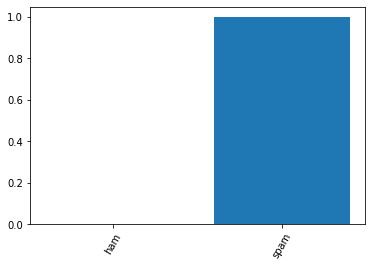

In [ ]:
model.eval()

df_test = pd.DataFrame( data = [user_text],
                       columns= ["tweet"])

ds_test = SpamLineByLineDataset(df_test, tokenizer=tokenizer)
dl_test = DataLoader(ds_test, batch_size = 8, shuffle=False)

data = next(iter(dl_test))


ids = data['ids'].to(device, dtype = torch.long)
mask = data['mask'].to(device, dtype = torch.long)
token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
targets = data['label'].to(device, dtype = torch.int64)

outputs = model(ids, mask, token_type_ids)

predicted_label = outputs.argmax(dim=1).cpu().numpy()

probs = torch.softmax( outputs, dim=1).detach().cpu().numpy()

for idx, l in enumerate(predicted_label):

  print( f" text: {df_test.loc[idx].tweet[:]} \n label: {idx2label[l]} \n probability to be spam: {probs[idx][label2idx['spam']]}")
  plt.bar( range(2), height=probs[idx])
  plt.xticks( range(2), label2idx.keys(), rotation='60')
  plt.show()
  